In [14]:
library(ggplot2)
library(tidyverse)
library(dplyr)
library(magrittr)
library(RSQLite)
library(tidyr)
library(lubridate)
library(stringr)
library(arules)
options(warn=-1)

In [16]:
setwd("C:/Users/Anuj/Desktop/Fall Term/Project/Telco")
df <- read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
head(df)

Parsed with column specification:
cols(
  .default = col_character(),
  SeniorCitizen = col_double(),
  tenure = col_double(),
  MonthlyCharges = col_double(),
  TotalCharges = col_double()
)
See spec(...) for full column specifications.


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


# *Section I*
## Telcom Business Landscape

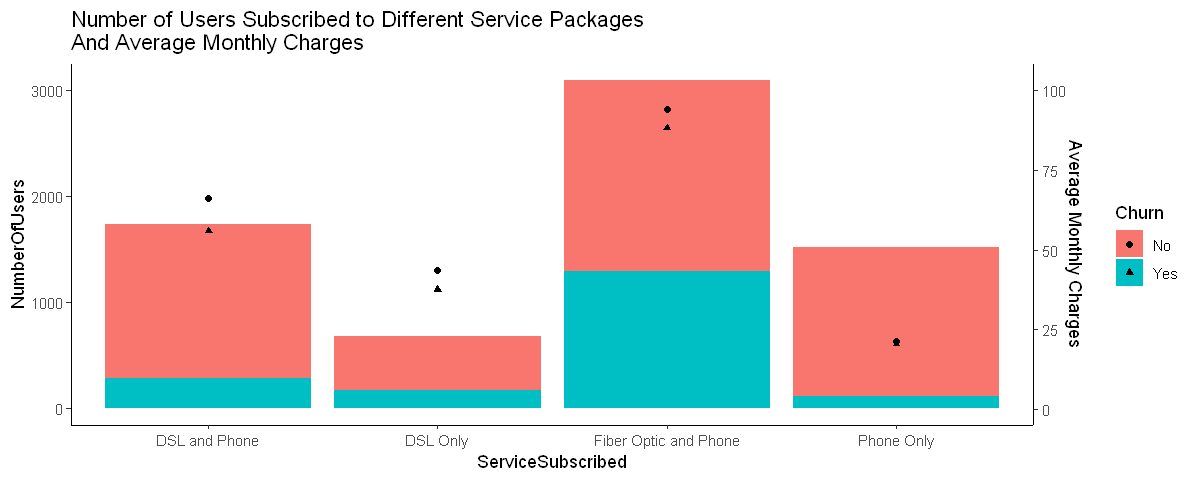

In [30]:
options(repr.plot.width =10, repr.plot.height = 4)
df %>% group_by(PhoneService, InternetService, Churn) %>% 
  summarise(NumberOfUsers = n(), AvgMonthlyCharges=mean(MonthlyCharges)) %>%
  add_column(ServiceSubscribed = c("DSL Only", "DSL Only", "DSL and Phone", "DSL and Phone","Fiber Optic and Phone","Fiber Optic and Phone","Phone Only","Phone Only")) %>%
  ggplot(aes(x=ServiceSubscribed, y=NumberOfUsers, fill=Churn)) + geom_bar(stat = 'identity') + theme_classic() + labs(title = "Number of Users Subscribed to Different Service Packages \nAnd Average Monthly Charges") + geom_point(aes(x=ServiceSubscribed,y=AvgMonthlyCharges * 30, group=1, shape=Churn), inherit.aes = FALSE) + scale_y_continuous(sec.axis = sec_axis(~. /30, name = "Average Monthly Charges"))

There are two types of contract with the company, one for internet and one for phone service. As we can see from the graph, the main revenue generating business are Fiber Optic and Phone services packages with more than 3000 users subscribed. Whereas, around 750 customers only subscribe to DSL internet service.
When it comes to assumptions about users churning, the naive thoughts top off our heads are pricing. We thought users churn because they are charged with too high a price, however this plot contradicts this assumption, in that across 4 service packages,  retaining users are actually spending more on average per month than churned users.
In addition, in our intuitive sense, we think people who engaged with the company more (users who have more service with the company) should be less likely to churn. However, Fiber Optic and Phone Service package users have the highest churning rate among them. Users who only subscribe to phone services actually have the least percentage of churning around 10%. It is known that retaining an existing customer costs less than acquiring new users.
As Fiber Optic and Phone service users bring us the most revenue, we naturally want to analyze why fiber optic and phone users have higher churn rate and how to retain them? 

### What affects fiber optic users to churn? 
Let’s narrow down to users who subscribed to fiber optic and phone service. With the assumption that package bundles have a difference on churn rate, we plot the dynamics of service bundles and churn.
We find that streaming service did not have much difference.

In [27]:
library(gridExtra)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



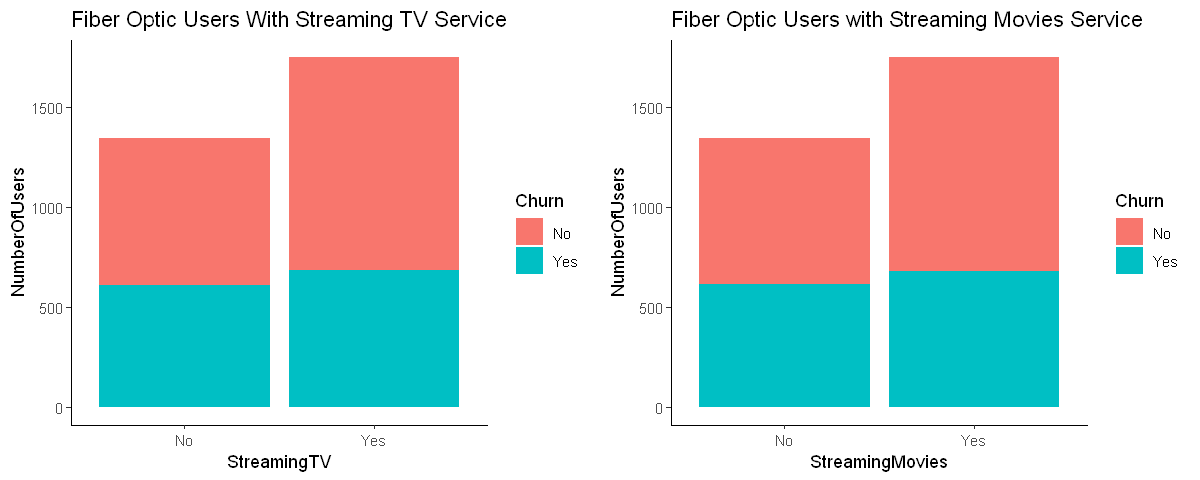

In [29]:
options(repr.plot.width =10, repr.plot.height = 4)
p1 <- df %>% filter(InternetService =='Fiber optic') %>% 
  group_by(StreamingTV,Churn) %>%
  summarise(NumberOfUsers = n()) %>% 
  ggplot(aes(x=StreamingTV, y=NumberOfUsers, fill = Churn)) + geom_bar(stat='identity') + theme_classic() + labs(title = "Fiber Optic Users With Streaming TV Service") 

#options(repr.plot.width =4, repr.plot.height = 4)
p2 <- df %>% filter(InternetService =='Fiber optic') %>% 
  group_by(StreamingMovies,Churn) %>%
  summarise(NumberOfUsers = n()) %>% 
  ggplot(aes(x=StreamingMovies, y=NumberOfUsers, fill = Churn)) + geom_bar(stat='identity') + theme_classic() + labs(title = "Fiber Optic Users with Streaming Movies Service ") 

grid.arrange(p1, p2, nrow = 1)

However, users who have security services are less likely to churn. We define security related services as online security, online backup, tech support, device protection.

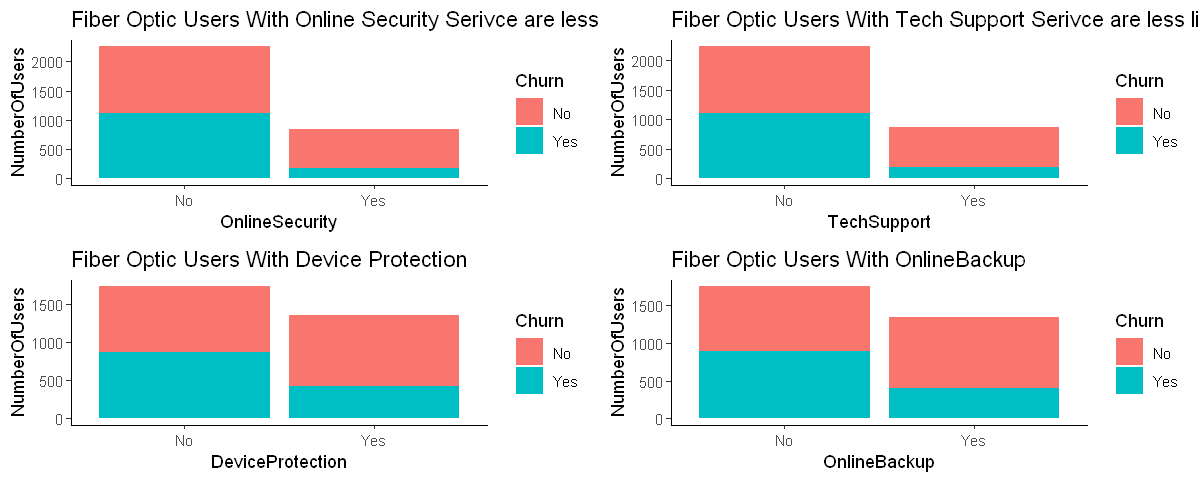

In [31]:
options(repr.plot.width =10, repr.plot.height = 4)

p3 <- df %>% filter(InternetService =='Fiber optic') %>% 
  group_by(OnlineSecurity,Churn) %>%
  summarise(NumberOfUsers = n()) %>% 
  ggplot(aes(x=OnlineSecurity, y=NumberOfUsers, fill = Churn)) + geom_bar(stat='identity') + theme_classic() + labs(title = "Fiber Optic Users With Online Security Serivce are less likely to churn") 


p4 <- df %>% filter(InternetService =='Fiber optic') %>% 
  group_by(TechSupport,Churn) %>%
  summarise(NumberOfUsers = n()) %>% 
  ggplot(aes(x=TechSupport, y=NumberOfUsers, fill = Churn)) + geom_bar(stat='identity') + theme_classic() + labs(title = "Fiber Optic Users With TechSupport") + labs(title = "Fiber Optic Users With Tech Support Serivce are less likely to churn") 


p5 <- df %>% filter(InternetService =='Fiber optic') %>% 
  group_by(DeviceProtection,Churn) %>%
  summarise(NumberOfUsers = n()) %>% 
  ggplot(aes(x=DeviceProtection, y=NumberOfUsers, fill = Churn)) + geom_bar(stat='identity') + theme_classic() + labs(title = "Fiber Optic Users With Device Protection") 


p6 <- df %>% filter(InternetService =='Fiber optic') %>% 
  group_by(OnlineBackup,Churn) %>%
  summarise(NumberOfUsers = n()) %>% 
  ggplot(aes(x=OnlineBackup, y=NumberOfUsers, fill = Churn)) + geom_bar(stat='identity') + theme_classic() + labs(title = "Fiber Optic Users With OnlineBackup") 

grid.arrange(p3, p4, p5, p6, nrow = 2)